## Density Estimation Using Real NVP - Simple Tutorial

From: https://github.com/TinyVolt/normalizing-flows/blob/main/realnvp_2d/RealNVP_2d.ipynb

The basic idea behind Real NVP is to construct a bijective transformation/flow between latent variables and observed variables such that the transformation satisfies:

1. It is invertible and the determinant of its Jacobian matrix is easy to compute
2. It is flexible such that it can transform random variables of simple distributions into random variables of complex distributions

Other prominent implementations can be found here:

1. https://github.com/fmu2/realNVP/tree/master
2. https://github.com/kamenbliznashki/normalizing_flows

### Import Libraries

In [1]:
from torch.distributions.normal import Normal

#from main import train_and_eval, train_loader, test_loader
import numpy as np
import torch
import time

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class NumpyDataset(data.Dataset):
    def __init__(self, array):
        super().__init__()
        self.array = array

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        return self.array[index]

In [3]:
n_train, n_test = 10000, 1000
train_data, train_labels = make_moons(n_samples=n_train, noise=0.05)
test_data, test_labels = make_moons(n_samples=n_test, noise=0.05)

train_loader = data.DataLoader(NumpyDataset(train_data), batch_size=128, shuffle=True)
test_loader = data.DataLoader(NumpyDataset(test_data), batch_size=128, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

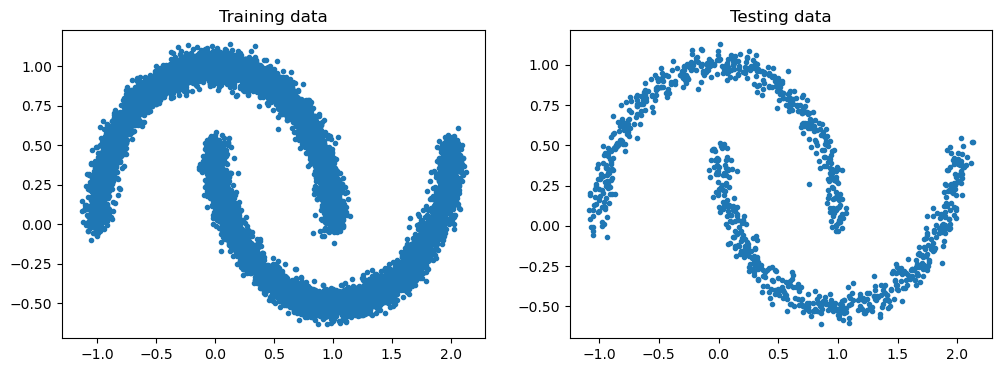

In [4]:
_, axes = plt.subplots(1,2,figsize=(12,4))
x,y = train_loader.dataset.array[:,0], train_loader.dataset.array[:,1]
_ = axes[0].plot(x,y,".")
_ = axes[0].set_title('Training data')

x,y = test_loader.dataset.array[:,0], test_loader.dataset.array[:,1]
_ = axes[1].plot(x,y,".")
_ = axes[1].set_title('Testing data')

In [5]:
def loss_function(target_distribution, z, log_det_jacobian):
    #print(log_det_jacobian.sum(1))
    #print(target_distribution.log_prob(z.cpu()).sum(1).to(device))
    
    log_likelihood = target_distribution.log_prob(z.cpu()).sum(1).to(device) + log_det_jacobian.sum(1)
    return -log_likelihood.mean()

def train(model, train_loader, optimizer, target_distribution, device):
    model.train()
    for x in train_loader:
        x = x.float().to(device)
        z, dz_by_dx = model(x)
        loss = loss_function(target_distribution, z, dz_by_dx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def eval_loss(model, data_loader, target_distribution, device):
    model.eval()
    total_loss = 0
    for x in data_loader:
        x = x.float().to(device)
        z, dz_by_dx = model(x)
        loss = loss_function(target_distribution, z, dz_by_dx)
        total_loss += loss * x.size(0)
    return (total_loss / len(data_loader.dataset)).item()

def train_and_eval(epochs, lr, train_loader, test_loader, target_distribution):

    #device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')         # device to train on
    transforms = [AffineTransform2D(True), AffineTransform2D(False), AffineTransform2D(True), AffineTransform2D(False)]
    flow = RealNVP(transforms).to(device)
    
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train(flow, train_loader, optimizer, target_distribution, device)
        train_loss = eval_loss(flow, train_loader, target_distribution, device)
        test_loss = eval_loss(flow, test_loader, target_distribution, device)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        #if (epoch + 1) % 1000 == 0:
        if (epoch + 1) % (epochs/10) == 0:
        #if (epoch + 1) % 1 == 0:
            print(f"Epoch: {epoch:}, train loss: {train_loss:.5f}, test loss: {test_loss:.5f}")
            #torch.save(realNVP.state_dict(), save_path+'/epoch_'+str(epoch)+'.pth')
            
    return flow, train_losses, test_losses

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, output_size):
        super(MLP, self).__init__()
        layers = [nn.Linear(input_size, hidden_size)]
        for _ in range(num_hidden_layers - 1):
            layers.append( nn.Linear(hidden_size, hidden_size) )
            layers.append( nn.ReLU() )
        layers.append( nn.Linear(hidden_size, output_size) )
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class AffineTransform2D(nn.Module):
    def __init__(self, left, hidden_size=128, num_hidden_layers=3):
        super(AffineTransform2D, self).__init__()
        self.mlp = MLP(2, hidden_size, num_hidden_layers, 2)
        self.mask = torch.FloatTensor([1,0]) if left else torch.FloatTensor([0,1])
        self.mask = self.mask.view(1,-1).to(device)
        self.scale_scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.shift_scale = nn.Parameter(torch.zeros(1), requires_grad=True)

    def forward(self, x, reverse=False):
        # x.size() is (B,2)
        #print(x)
        #print(self.mask)
        x_masked = x * self.mask
        # log_scale and shift have size (B,1)
        log_scale, shift = self.mlp(x_masked).chunk(2, dim=1)
        log_scale = log_scale.tanh() * self.scale_scale + self.shift_scale
        # log_scale and shift have size (B,2)
        shift = shift  * (1-self.mask)
        log_scale = log_scale * (1-self.mask)
        if reverse:
            x = (x - shift) * torch.exp(-log_scale)
        else:
            x = x * torch.exp(log_scale) + shift
        return x, log_scale


class RealNVP(nn.Module):
    def __init__(self, affine_transforms):
        super(RealNVP, self).__init__()
        self.transforms = nn.ModuleList(affine_transforms)

    def forward(self, x):
        z, log_det_jacobian = x, torch.zeros_like(x)
        for transform in self.transforms:
            z, log_scale = transform(z)
            log_det_jacobian += log_scale
        return z, log_det_jacobian

    def invert(self, z):
        for transform in self.transforms[::-1]:
            z, _ = transform(z)
        return z

In [7]:
## Seed random generators
SEED = 3    
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## generate distribution
mu = torch.FloatTensor([0.])
sigma = torch.FloatTensor([1.])
target_distribution = Normal(mu, sigma)

epochs = 1000

start = time.time()
#flow, train_losses, test_losses = train_and_eval(epochs, 1e-3, train_loader, test_loader, target_distribution)

lr = 1e-3
transforms = [AffineTransform2D(True), AffineTransform2D(False), AffineTransform2D(True), AffineTransform2D(False)]
flow = RealNVP(transforms).to(device)

optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
train_losses, test_losses = [], []
for epoch in range(epochs):
    train(flow, train_loader, optimizer, target_distribution, device)
    train_loss = eval_loss(flow, train_loader, target_distribution, device)
    test_loss = eval_loss(flow, test_loader, target_distribution, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    #if (epoch + 1) % 1000 == 0:
    if (epoch + 1) % (epochs/10) == 0:
    #if (epoch + 1) % 1 == 0:
        print(f"Epoch: {epoch:}, train loss: {train_loss:.5f}, test loss: {test_loss:.5f}")
        #torch.save(realNVP.state_dict(), save_path+'/epoch_'+str(epoch)+'.pth')


end = time.time()
print("Elapsed time: {} seconds".format(end-start))

Epoch: 99, train loss: 0.45507, test loss: 0.47381
Epoch: 199, train loss: 0.46490, test loss: 0.44357
Epoch: 299, train loss: 0.46036, test loss: 0.46817
Epoch: 399, train loss: 0.39367, test loss: 0.42961
Epoch: 499, train loss: 0.41988, test loss: 0.45166
Epoch: 599, train loss: 0.39341, test loss: 0.40433
Epoch: 699, train loss: 0.42342, test loss: 0.44574
Epoch: 799, train loss: 0.37033, test loss: 0.41392
Epoch: 899, train loss: 0.44634, test loss: 0.45212
Epoch: 999, train loss: 0.39686, test loss: 0.42710
Elapsed time: 592.8362259864807 seconds


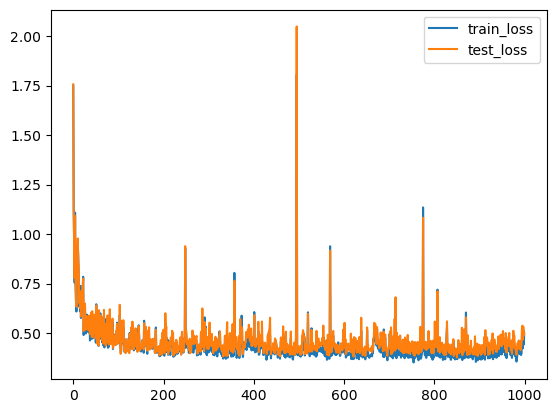

In [8]:
_ = plt.plot(train_losses, label='train_loss')
_ = plt.plot(test_losses, label='test_loss')
_ = plt.legend()

In [11]:
with torch.no_grad():
    z, _ = flow(torch.FloatTensor(test_loader.dataset.array))
    z_a = z.cpu().numpy()
    plt.scatter(z_a[:,0], z_a[:,1])

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
with torch.no_grad():
    x_inv = flow.invert(z)
    x_inv = x_inv.cpu().numpy()
    #plt.scatter(x_inv[:,0], x_inv[:,1])

   
    fig = plt.figure(2, figsize = (12.8, 4.8))
    fig.clf()
    plt.subplot(1,2,1)
    plt.scatter(z[:,0], z[:,1])
    #plt.plot(X[label==0,0], X[label==0,1], ".")
    #plt.plot(X[label==1,0], X[label==1,1], ".")
    plt.title("z sampled from Moon dataset")
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    
    plt.subplot(1,2,2)
    plt.scatter(x_inv[:,0], x_inv[:,1])
    #plt.plot(z[label==0,0], z[label==0,1], ".")
    #plt.plot(z[label==1,0], z[label==1,1], ".")
    plt.title("x transformed from z")
    plt.xlabel(r"$z_1$")
    plt.ylabel(r"$z_2$")
    plt.show()
    